# Change to LR mode:
To extend the task scheduling model to support logical space constraints per bin, we’ll enhance it in the following ways:

Each bin now has a set of available spaces (like "L", "R", "D").

Each task includes a logical expression of the required spaces.

We’ll only allow a task to be assigned to a bin if the bin’s available spaces satisfy the task's logical requirement.

In [1]:
"""
Nested Space Expression Scheduler using OR-Tools

This script supports task scheduling with precedence constraints and nested logical
resource requirements per bin (e.g., '(L or R) and not D').

Features:
- Parsing and evaluating logical space expressions with nested structure
- Building constraints using OR-Tools CP-SAT solver
- Generating Gantt charts and task-resource usage plots
- Unit tests for malformed logical expressions

Main Components:
- `ExprNode`: AST structure for logical expressions
- `tokenize`, `parse_expression`: converts string expression to logical tree
- `build_expression_constraint`: constructs OR-Tools constraints recursively
- `build_task_model`: schedules tasks over time and space given resource logic
- `export_expr_tree_*`: save expression tree as JSON or .png
- `test_invalid_expression_parsing`: validation utility

Usage:
- Define `tasks` and `bin_spaces`
- Call `schedule_tasks_with_space_literals(tasks, bin_spaces, debug=True)`
"""


from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import re
import json

# ----------- LOGIC TREE PARSING -----------

class ExprNode:
    """Node of the logical expression tree."""
    def __init__(self, kind, value=None, left=None, right=None):
        self.kind = kind  # 'VAR', 'AND', 'OR', 'NOT'
        self.value = value
        self.left = left
        self.right = right

    def to_dict(self):
        """Convert expression tree to a JSON-serializable dictionary."""
        return {
            'kind': self.kind,
            'value': self.value,
            'left': self.left.to_dict() if self.left else None,
            'right': self.right.to_dict() if self.right else None
        }

    def __repr__(self, indent=0):
        pad = '  ' * indent
        if self.kind == 'VAR':
            return f"{pad}{self.value}"
        elif self.kind == 'NOT':
            return f"{pad}NOT\n{self.left.__repr__(indent + 1)}"
        else:
            return f"{pad}{self.kind}\n{self.left.__repr__(indent + 1)}\n{self.right.__repr__(indent + 1)}"


def tokenize(expr):
    """Tokenizes logical expressions into a list of symbols with regular expressions (re)."""
    return re.findall(r'\w+|[()]', expr)


def parse_expression(tokens):
    """Parses tokens into an expression tree using recursive descent."""
    def parse_primary():
        if not tokens:
            raise ValueError("Unexpected end of tokens while parsing.")
        token = tokens.pop(0)
        if token == '(':
            node = parse_or()
            if not tokens or tokens.pop(0) != ')':
                raise ValueError("Expected closing parenthesis")
            return node
        elif token == 'not':
            return ExprNode('NOT', left=parse_primary())
        else:
            return ExprNode('VAR', value=token)

    def parse_and():
        node = parse_primary()
        while tokens and tokens[0] == 'and':
            tokens.pop(0)
            node = ExprNode('AND', left=node, right=parse_primary())
        return node

    def parse_or():
        node = parse_and()
        while tokens and tokens[0] == 'or':
            tokens.pop(0)
            node = ExprNode('OR', left=node, right=parse_and())
        return node

    return parse_or()


def print_expr_tree(node, indent=0):
    """Prints a logical expression tree in readable form."""
    if node is None:
        return
    print("  " * indent + f"{node.kind}: {node.value if node.value else ''}")
    print_expr_tree(node.left, indent + 1)
    print_expr_tree(node.right, indent + 1)


def export_expr_tree_json(expr_tree, filename):
    """Export logic expression tree to a JSON file."""
    with open(filename, 'w') as f:
        json.dump(expr_tree.to_dict(), f, indent=2)


def expression_matches_bin(expr_node, bin_space):
    """Recursively check if a bin satisfies the logical expression."""
    if expr_node.kind == 'VAR':
        return expr_node.value in bin_space
    elif expr_node.kind == 'NOT':
        return not expression_matches_bin(expr_node.left, bin_space)
    elif expr_node.kind == 'AND':
        return expression_matches_bin(expr_node.left, bin_space) and expression_matches_bin(expr_node.right, bin_space)
    elif expr_node.kind == 'OR':
        return expression_matches_bin(expr_node.left, bin_space) or expression_matches_bin(expr_node.right, bin_space)


def build_expression_constraint(model, expr_node, space_vars):
    """Recursively build OR-Tools constraints from an expression tree."""
    if expr_node.kind == 'VAR':
        return space_vars.get(expr_node.value, model.NewConstant(0))

    elif expr_node.kind == 'NOT':
        var = build_expression_constraint(model, expr_node.left, space_vars)
        not_var = model.NewBoolVar('not_expr')
        model.Add(var == 0).OnlyEnforceIf(not_var)
        model.Add(var == 1).OnlyEnforceIf(not_var.Not())
        return not_var

    elif expr_node.kind == 'AND':
        a = build_expression_constraint(model, expr_node.left, space_vars)
        b = build_expression_constraint(model, expr_node.right, space_vars)
        and_var = model.NewBoolVar('and_expr')
        model.AddBoolAnd([a, b]).OnlyEnforceIf(and_var)
        model.AddBoolOr([a.Not(), b.Not()]).OnlyEnforceIf(and_var.Not())
        return and_var

    elif expr_node.kind == 'OR':
        a = build_expression_constraint(model, expr_node.left, space_vars)
        b = build_expression_constraint(model, expr_node.right, space_vars)
        or_var = model.NewBoolVar('or_expr')
        model.AddBoolOr([a, b]).OnlyEnforceIf(or_var)
        model.AddBoolAnd([a.Not(), b.Not()]).OnlyEnforceIf(or_var.Not())
        return or_var

# ----------- SCHEDULING FUNCTIONS -----------

def build_task_model(tasks, bin_spaces, model, debug=False):
    """
    Create the scheduling variables and constraints for all tasks across bins.
    Each task has a logical expression on allowed resource labels.
    """
    task_ids = list(tasks.keys())
    n_bins = len(bin_spaces)
    horizon = sum(tasks[t]['tasktime'] for t in task_ids)
    task_index = {t: i for i, t in enumerate(task_ids)}

    start_vars, end_vars, bin_vars = [], [], []
    optional_intervals_per_bin = [[] for _ in range(n_bins)]
    task_space_usage = {}

    for i, t in enumerate(task_ids):
        duration = tasks[t]['tasktime']
        space_expr = tasks[t]['space_expr']
        start = model.NewIntVar(0, horizon, f'start_{t}')
        end = model.NewIntVar(0, horizon, f'end_{t}')
        bin_var = model.NewIntVar(0, n_bins - 1, f'bin_{t}')
        model.Add(end == start + duration)

        start_vars.append(start)
        end_vars.append(end)
        bin_vars.append(bin_var)
        task_space_usage[t] = {}

        tokens = tokenize(space_expr)
        ast = parse_expression(tokens)
        if debug:
            print(f"Expression Tree for Task {t}:")
            print_expr_tree(ast)

        valid_choices = []

        for b in range(n_bins):
            bin_space = bin_spaces[b]
            is_on_bin = model.NewBoolVar(f'is_{t}_on_bin_{b}')
            interval = model.NewOptionalIntervalVar(start, duration, end, is_on_bin, f'intv_{t}_bin_{b}')
            optional_intervals_per_bin[b].append(interval)

            # Create used_space_bools for every label in bin
            used_space_bools = {
                s: model.NewBoolVar(f'used_{t}_{s}_bin_{b}') for s in bin_space
            }

            for var in used_space_bools.values():
                model.Add(var == 0).OnlyEnforceIf(is_on_bin.Not())

            # Evaluate tree
            condition_met = build_expression_constraint(model, ast, used_space_bools)
            model.Add(condition_met == 1).OnlyEnforceIf(is_on_bin)

            model.Add(bin_var == b).OnlyEnforceIf(is_on_bin)
            model.Add(bin_var != b).OnlyEnforceIf(is_on_bin.Not())
            task_space_usage[t][b] = used_space_bools
            valid_choices.append(is_on_bin)

        model.AddExactlyOne(valid_choices)

    return task_ids, task_index, start_vars,\
            end_vars, bin_vars, optional_intervals_per_bin, task_space_usage, horizon


def apply_prerequisite_constraints(model, tasks, task_index, start_vars, end_vars, horizon):
    """Ensure that each task starts only after all its prerequisites have ended."""
    for i, t in enumerate(tasks):
        prereqs = tasks[t]['prerequisites']
        if prereqs:
            ends = [end_vars[task_index[p]] for p in prereqs]
            max_end = model.NewIntVar(0, horizon, f'maxend_{t}')
            model.AddMaxEquality(max_end, ends)
            model.Add(start_vars[i] >= max_end)


def extract_schedule(solver, task_ids, task_index, bin_vars, start_vars, end_vars, task_space_usage):
    """Extract solution: task-bin assignments, time intervals, and space labels used."""
    schedule = []
    for i, t in enumerate(task_ids):
        b = solver.Value(bin_vars[i])
        s = solver.Value(start_vars[i])
        e = solver.Value(end_vars[i])
        used_spaces = [sp for sp, var in task_space_usage[t].get(b, {}).items() if solver.Value(var)]
        schedule.append({'task': t, 'bin': b, 'start': s, 'end': e, 'spaces': used_spaces})
    return schedule


def plot_schedule_gantt(schedule, bin_spaces, task_index):
    """Plot a Gantt chart showing task allocation per bin and resource label."""
    label_idx = {}
    all_labels = []
    idx = 0
    for b, spaces in enumerate(bin_spaces):
        for s in spaces:
            label = f"Bin {b} - {s}"
            label_idx[(b, s)] = idx
            all_labels.append(label)
            idx += 1

    fig, ax = plt.subplots(figsize=(12, 0.5 * len(all_labels) + 1))
    colors = plt.cm.tab10.colors
    for item in schedule:
        for s in item['spaces']:
            y = label_idx[(item['bin'], s)]
            ax.barh(y, item['end'] - item['start'], left=item['start'],
                    color=colors[task_index[item['task']] % len(colors)], edgecolor='black')
            ax.text(item['start'] + 0.1, y, item['task'], va='center', ha='left', fontsize=9)

    ax.set_yticks(range(len(all_labels)))
    ax.set_yticklabels(all_labels)
    ax.set_xlabel("Time")
    ax.set_title("Gantt Chart by Actual Bin Space Usage")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def schedule_tasks_with_space_literals(tasks, bin_spaces, show_gantt=True, debug=False):
    """
    Solve task scheduling problem with logical space expressions and output schedule.
    
    Arguments:
    - tasks: dict of task definitions with 'tasktime', 'prerequisites', and 'space_expr'
    - bin_spaces: list of resource labels per bin
    - show_gantt: whether to display Gantt chart of schedule
    - debug: if True, prints expression tree of each task

    Returns:
    - schedule: list of scheduled tasks with times, bins, and used labels
    - makespan: total schedule duration
    """
    model = cp_model.CpModel()
    (task_ids, task_index, start_vars, end_vars, bin_vars,
     optional_intervals_per_bin, task_space_usage, horizon) = build_task_model(tasks, bin_spaces, model, debug)

    for b_intervals in optional_intervals_per_bin:
        model.AddNoOverlap(b_intervals)

    apply_prerequisite_constraints(model, tasks, task_index, start_vars, end_vars, horizon)

    makespan = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(makespan, end_vars)
    model.Minimize(makespan)

    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status not in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        print("ERROR: No feasible solution. Check expressions below:")
        for t, info in tasks.items():
            print(f"{t}: {info['space_expr']}")
        raise RuntimeError("Infeasible.")
    elif status in [cp_model.FEASIBLE]:
        print("WARNING: potential suboptimal solution.")

    schedule = extract_schedule(solver, task_ids, task_index, bin_vars, start_vars, end_vars, task_space_usage)
    if show_gantt:
        plot_schedule_gantt(schedule, bin_spaces, task_index)

    return schedule, solver.ObjectiveValue()


# 1. Simple test sample

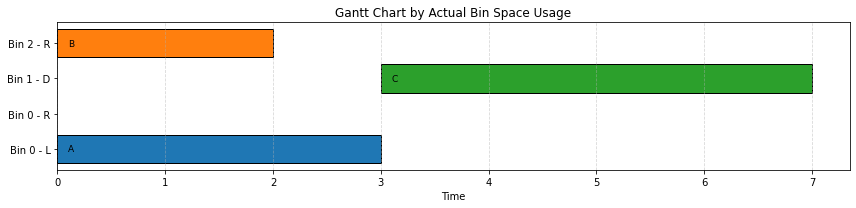

([{'task': 'A', 'bin': 0, 'start': 0, 'end': 3, 'spaces': ['L']},
  {'task': 'B', 'bin': 2, 'start': 0, 'end': 2, 'spaces': ['R']},
  {'task': 'C', 'bin': 1, 'start': 3, 'end': 7, 'spaces': ['D']}],
 7.0)

In [2]:
tasks = {
    'A': {'tasktime': 3, 'prerequisites': [], 'space_expr': 'L or D'},
    'B': {'tasktime': 2, 'prerequisites': [], 'space_expr': 'L or R'},
    'C': {'tasktime': 4, 'prerequisites': ['A'], 'space_expr': 'D'},
}

bin_spaces = [
    ['L', 'R' ],        # Bin 0
    ['D'],             # Bin 1
    ['R'],   # Bin 2
]

schedule_tasks_with_space_literals(tasks, bin_spaces)

# 2. Complicated test sample

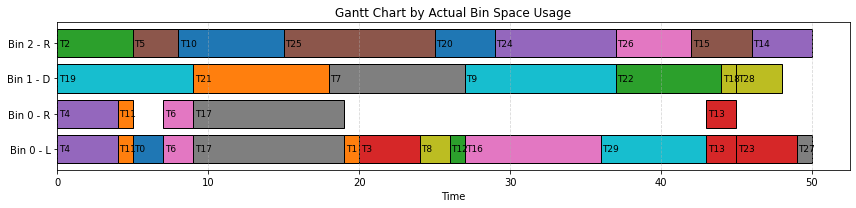

([{'task': 'T0', 'bin': 0, 'start': 5, 'end': 7, 'spaces': ['L']},
  {'task': 'T1', 'bin': 0, 'start': 19, 'end': 20, 'spaces': ['L']},
  {'task': 'T2', 'bin': 2, 'start': 0, 'end': 5, 'spaces': ['R']},
  {'task': 'T3', 'bin': 0, 'start': 20, 'end': 24, 'spaces': ['L']},
  {'task': 'T4', 'bin': 0, 'start': 0, 'end': 4, 'spaces': ['L', 'R']},
  {'task': 'T5', 'bin': 2, 'start': 5, 'end': 8, 'spaces': ['R']},
  {'task': 'T6', 'bin': 0, 'start': 7, 'end': 9, 'spaces': ['L', 'R']},
  {'task': 'T7', 'bin': 1, 'start': 18, 'end': 27, 'spaces': ['D']},
  {'task': 'T8', 'bin': 0, 'start': 24, 'end': 26, 'spaces': ['L']},
  {'task': 'T9', 'bin': 1, 'start': 27, 'end': 37, 'spaces': ['D']},
  {'task': 'T10', 'bin': 2, 'start': 8, 'end': 15, 'spaces': ['R']},
  {'task': 'T11', 'bin': 0, 'start': 4, 'end': 5, 'spaces': ['L', 'R']},
  {'task': 'T12', 'bin': 0, 'start': 26, 'end': 27, 'spaces': ['L']},
  {'task': 'T13', 'bin': 0, 'start': 43, 'end': 45, 'spaces': ['L', 'R']},
  {'task': 'T14', 'bin'

In [3]:
# The code to generate random test set:
# Current test set:
tasks =\
{'T0': {'tasktime': 2, 'prerequisites': [], 'space_expr': 'L'},
 'T1': {'tasktime': 1, 'prerequisites': ['T0'], 'space_expr': 'L'},
 'T2': {'tasktime': 5, 'prerequisites': [], 'space_expr': 'R'},
 'T3': {'tasktime': 4, 'prerequisites': ['T1'], 'space_expr': 'L or R'},
 'T4': {'tasktime': 4, 'prerequisites': [], 'space_expr': 'L and R'},
 'T5': {'tasktime': 3, 'prerequisites': [], 'space_expr': 'R'},
 'T6': {'tasktime': 2,
  'prerequisites': ['T0', 'T2', 'T4'],
  'space_expr': 'L and R'},
 'T7': {'tasktime': 9, 'prerequisites': ['T6', 'T0'], 'space_expr': 'D'},
 'T8': {'tasktime': 2, 'prerequisites': ['T1', 'T3', 'T0'], 'space_expr': 'L'},
 'T9': {'tasktime': 10, 'prerequisites': ['T5', 'T3'], 'space_expr': 'D'},
 'T10': {'tasktime': 7, 'prerequisites': [], 'space_expr': 'L or R or D'},
 'T11': {'tasktime': 1, 'prerequisites': [], 'space_expr': 'L and R'},
 'T12': {'tasktime': 1, 'prerequisites': ['T4'], 'space_expr': 'L or R'},
 'T13': {'tasktime': 2, 'prerequisites': [], 'space_expr': 'L and R'},
 'T14': {'tasktime': 4, 'prerequisites': ['T13'], 'space_expr': 'R'},
 'T15': {'tasktime': 4, 'prerequisites': [], 'space_expr': 'L or R'},
 'T16': {'tasktime': 9,
  'prerequisites': ['T8', 'T7', 'T10'],
  'space_expr': 'L'},
 'T17': {'tasktime': 10,
  'prerequisites': ['T5', 'T11'],
  'space_expr': 'L and R'},
 'T18': {'tasktime': 1, 'prerequisites': ['T6', 'T8'], 'space_expr': 'D'},
 'T19': {'tasktime': 9, 'prerequisites': [], 'space_expr': 'D'},
 'T20': {'tasktime': 4, 'prerequisites': ['T17'], 'space_expr': 'L or R'},
 'T21': {'tasktime': 9, 'prerequisites': ['T5'], 'space_expr': 'D'},
 'T22': {'tasktime': 7,
  'prerequisites': ['T12', 'T8', 'T20'],
  'space_expr': 'D'},
 'T23': {'tasktime': 4, 'prerequisites': ['T21'], 'space_expr': 'L'},
 'T24': {'tasktime': 8, 'prerequisites': ['T1', 'T7'], 'space_expr': 'L or R'},
 'T25': {'tasktime': 10, 'prerequisites': [], 'space_expr': 'L or R'},
 'T26': {'tasktime': 5, 'prerequisites': ['T12', 'T8'], 'space_expr': 'R'},
 'T27': {'tasktime': 1, 'prerequisites': [], 'space_expr': 'L'},
 'T28': {'tasktime': 3, 'prerequisites': ['T18'], 'space_expr': 'D'},
 'T29': {'tasktime': 7, 'prerequisites': ['T6', 'T20'], 'space_expr': 'L'}}

bin_spaces = [
    ['L', 'R' ],        # Bin 0
    ['D'],             # Bin 1
    ['R'],   # Bin 2
]

schedule_tasks_with_space_literals(tasks, bin_spaces)

# 3. Test same sample but with more bins

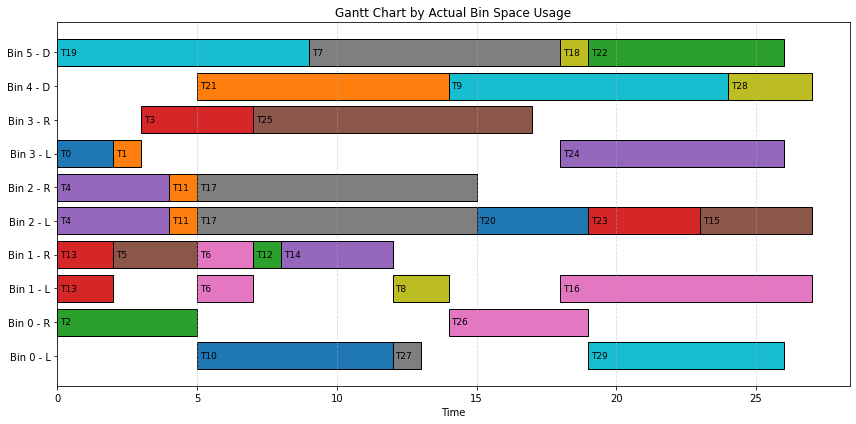

[{'task': 'T0', 'bin': 3, 'start': 0, 'end': 2, 'spaces': ['L']}, {'task': 'T1', 'bin': 3, 'start': 2, 'end': 3, 'spaces': ['L']}, {'task': 'T2', 'bin': 0, 'start': 0, 'end': 5, 'spaces': ['R']}, {'task': 'T3', 'bin': 3, 'start': 3, 'end': 7, 'spaces': ['R']}, {'task': 'T4', 'bin': 2, 'start': 0, 'end': 4, 'spaces': ['L', 'R']}, {'task': 'T5', 'bin': 1, 'start': 2, 'end': 5, 'spaces': ['R']}, {'task': 'T6', 'bin': 1, 'start': 5, 'end': 7, 'spaces': ['L', 'R']}, {'task': 'T7', 'bin': 5, 'start': 9, 'end': 18, 'spaces': ['D']}, {'task': 'T8', 'bin': 1, 'start': 12, 'end': 14, 'spaces': ['L']}, {'task': 'T9', 'bin': 4, 'start': 14, 'end': 24, 'spaces': ['D']}, {'task': 'T10', 'bin': 0, 'start': 5, 'end': 12, 'spaces': ['L']}, {'task': 'T11', 'bin': 2, 'start': 4, 'end': 5, 'spaces': ['L', 'R']}, {'task': 'T12', 'bin': 1, 'start': 7, 'end': 8, 'spaces': ['R']}, {'task': 'T13', 'bin': 1, 'start': 0, 'end': 2, 'spaces': ['L', 'R']}, {'task': 'T14', 'bin': 1, 'start': 8, 'end': 12, 'spaces': 

In [4]:
# The code to generate random test set:
# Current test set:
tasks =\
{'T0': {'tasktime': 2, 'prerequisites': [], 'space_expr': 'L'},
 'T1': {'tasktime': 1, 'prerequisites': ['T0'], 'space_expr': 'L'},
 'T2': {'tasktime': 5, 'prerequisites': [], 'space_expr': 'R'},
 'T3': {'tasktime': 4, 'prerequisites': ['T1'], 'space_expr': 'L or R'},
 'T4': {'tasktime': 4, 'prerequisites': [], 'space_expr': 'L and R'},
 'T5': {'tasktime': 3, 'prerequisites': [], 'space_expr': 'R'},
 'T6': {'tasktime': 2,
  'prerequisites': ['T0', 'T2', 'T4'],
  'space_expr': 'L and R'},
 'T7': {'tasktime': 9, 'prerequisites': ['T6', 'T0'], 'space_expr': 'D'},
 'T8': {'tasktime': 2, 'prerequisites': ['T1', 'T3', 'T0'], 'space_expr': 'L'},
 'T9': {'tasktime': 10, 'prerequisites': ['T5', 'T3'], 'space_expr': 'D'},
 'T10': {'tasktime': 7, 'prerequisites': [], 'space_expr': 'L or R or D'},
 'T11': {'tasktime': 1, 'prerequisites': [], 'space_expr': 'L and R'},
 'T12': {'tasktime': 1, 'prerequisites': ['T4'], 'space_expr': 'L or R'},
 'T13': {'tasktime': 2, 'prerequisites': [], 'space_expr': 'L and R'},
 'T14': {'tasktime': 4, 'prerequisites': ['T13'], 'space_expr': 'R'},
 'T15': {'tasktime': 4, 'prerequisites': [], 'space_expr': 'L or R'},
 'T16': {'tasktime': 9,
  'prerequisites': ['T8', 'T7', 'T10'],
  'space_expr': 'L'},
 'T17': {'tasktime': 10,
  'prerequisites': ['T5', 'T11'],
  'space_expr': 'L and R'},
 'T18': {'tasktime': 1, 'prerequisites': ['T6', 'T8'], 'space_expr': 'D'},
 'T19': {'tasktime': 9, 'prerequisites': [], 'space_expr': 'D'},
 'T20': {'tasktime': 4, 'prerequisites': ['T17'], 'space_expr': 'L or R'},
 'T21': {'tasktime': 9, 'prerequisites': ['T5'], 'space_expr': 'D'},
 'T22': {'tasktime': 7,
  'prerequisites': ['T12', 'T8', 'T20'],
  'space_expr': 'D'},
 'T23': {'tasktime': 4, 'prerequisites': ['T21'], 'space_expr': 'L'},
 'T24': {'tasktime': 8, 'prerequisites': ['T1', 'T7'], 'space_expr': 'L or R'},
 'T25': {'tasktime': 10, 'prerequisites': [], 'space_expr': 'L or R'},
 'T26': {'tasktime': 5, 'prerequisites': ['T12', 'T8'], 'space_expr': 'R'},
 'T27': {'tasktime': 1, 'prerequisites': [], 'space_expr': 'L'},
 'T28': {'tasktime': 3, 'prerequisites': ['T18'], 'space_expr': 'D'},
 'T29': {'tasktime': 7, 'prerequisites': ['T6', 'T20'], 'space_expr': 'L'}}

bin_spaces = [
    ['L', 'R' ],        # Bin 0
    ['L', 'R' ],        # Bin 1
    ['L', 'R' ],        # Bin 2
    ['L', 'R' ],        # Bin 3
    ['D'],             # Bin 4
    ['D'],   # Bin 5
]

task_schedule, time = schedule_tasks_with_space_literals(tasks, bin_spaces)
print(task_schedule)
print(time)

## 3.1. (OPTIONAL, require extra packages) Prerequisite Graph
requires `graphviz`

---

#### On macOS (using Homebrew):
```bash
brew install graphviz
```

#### On Ubuntu/Linux:
```bash
sudo apt-get install graphviz
```

#### On Windows:
1. Download from [graphviz.org](https://graphviz.org/download/)
2. Add the Graphviz `bin/` directory to your system's PATH.

---

In [8]:
from graphviz import Digraph

def plot_task_dependencies(tasks, filename='task_dependencies'):
    dot = Digraph(comment='Task Prerequisites')
    for task in tasks:
        dot.node(task)
        for prereq in tasks[task].get('prerequisites', []):
            dot.edge(prereq, task)

    dot.render(filename, format='png', cleanup=True)
    print(f"✅ Dependency graph saved to {filename}.png")

plot_task_dependencies(tasks)

✅ Dependency graph saved to task_dependencies.png


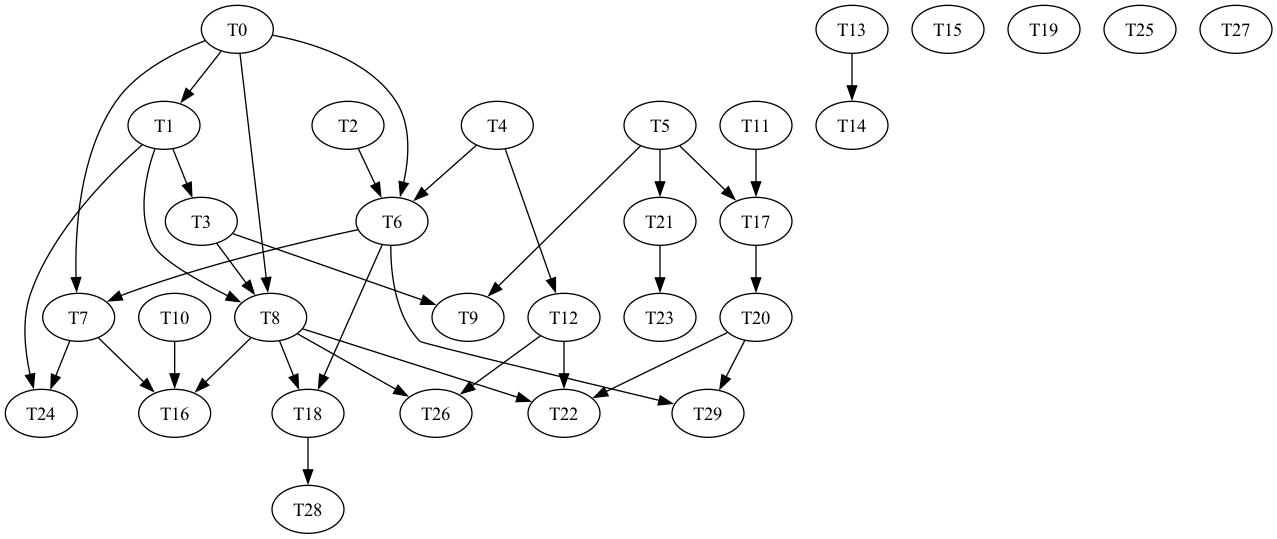

In [9]:
from IPython.display import Image, display

# Display local PNG file
display(Image(filename=f'./task_dependencies.png'))

# OR, display image from a URL
# display(Image(url='https://example.com/image.png'))


## 3.2. Further data analysis on the result

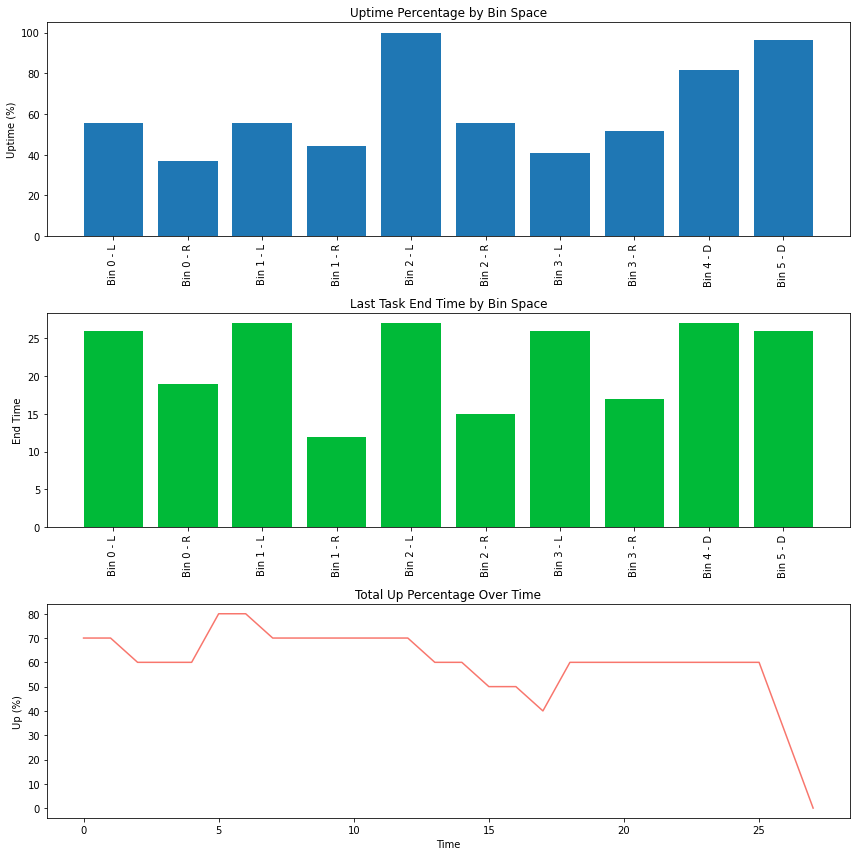

In [10]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Determine all unique bin-space combinations
bin_space_set = set()
max_time = 0
for task in schedule:
    max_time = max(max_time, task['end'])
    for s in task['spaces']:
        bin_space_set.add((task['bin'], s))

# (1) Uptime percentage per bin-space
from collections import defaultdict
uptime = defaultdict(int)
for task in schedule:
    for s in task['spaces']:
        uptime[(task['bin'], s)] += task['end'] - task['start']
uptime_percentage = {bs: t / max_time * 100 for bs, t in uptime.items()}

# (2) Uptime per time unit across all bin-spaces
timeline = [0] * (max_time + 1)
total_spaces = len(bin_space_set)
for task in schedule:
    for s in task['spaces']:
        for t in range(task['start'], task['end']):
            timeline[t] += 1
uptime_by_time = [u / total_spaces * 100 for u in timeline]

# (3) End time of last task using each bin-space
last_end = defaultdict(int)
for task in schedule:
    for s in task['spaces']:
        bs = (task['bin'], s)
        last_end[bs] = max(last_end[bs], task['end'])

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Sort by key (i.e., alphabetically)
uptime_percentage = dict(sorted(uptime_percentage.items()))
last_end = dict(sorted(last_end.items()))

# Plot (1)
labels_1 = [f"Bin {b} - {s}" for (b, s) in uptime_percentage.keys()]
values_1 = list(uptime_percentage.values())
axs[0].bar(labels_1, values_1)
axs[0].set_title("Uptime Percentage by Bin Space")
axs[0].set_ylabel("Uptime (%)")
axs[0].tick_params(axis='x', rotation=90)

# Plot (2)
axs[2].plot(range(len(uptime_by_time)), uptime_by_time, color = "#F8766D")
axs[2].set_title("Total Up Percentage Over Time")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Up (%)")

# Plot (3)
labels_3 = [f"Bin {b} - {s}" for (b, s) in last_end.keys()]
values_3 = list(last_end.values())
axs[1].bar(labels_3, values_3, color = "#00BA38")
axs[1].set_title("Last Task End Time by Bin Space")
axs[1].set_ylabel("End Time")
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()
